# Machine Learning Mid-term Project
Yong Chen Goh, Shane Richardson, Amaya Syed

In this project we use data from the Sloan Digital Sky Survey (SDSS) [1]. This is a multi-class classification problem consisting of three classes: Galaxy, Star, and Quasar (QSO), each with eight feature variables. We solve this problem using **Softmax Regression**.

Methodology:
- Import the data from the accompanying CSV file ('SDSS_10000.csv').

- Pre-processing:
    - Calculating and replacing redshift values with the natural logarithm of the redshift.
    - Converting the string values for 'class' into either 0, 1, or 2.
    - Normalising all feature values (with the exception of the redshift).
- Define key/helper functions:
    - 'data_preprocessing'.
    - 'data_split'.
    - 'test_and_training_data'.
    - 'accuracy'.
    - ‘softmax’.
    - ‘one_hot_encoder’.
    - 'class_list_sorted'.
    - ‘cost_function’, including a regularization term.
    - ‘gradient’.
    - 'mini-batch'.
    - 'mini-batch_gradient_descent'.
    - 'confusion_matrix'.
    - 'plot_confusion_matrix'.
    - 'cross_validation'.
- Exploratory data analysis.
- Feature importance analysis. Run mini-batch gradient descent using:
    - (Log) redshift only.
    - Spectral information only (u, g, r, i, z).
    - Positional information only ('ra' and 'dec').
    - Random numbers only, as a benchmark.
- Final training and testing using the most important features only (redshift, u, i, and z).
- Analysis of results.
- Convergence testing for different batch sizes.
- Conclusions.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.colors

import seaborn as sns
sns.set_style('whitegrid')

# Importing Data

We first upload the SDSS dataset into a Pandas DataFrame and display the first 5 rows. The eight feature values of interest are:

- Positional values:

    - ra: Right Ascension.
    - dec: Declination.
    
- The response of the five spectral telescope bands:

    - u: UV
    - g: green
    - r: red
    - i: infrared
    - z: near infrared
    
- Redshift: the displacement of spectral lines towards longer (redder) wavelengths. The value increases with the distance of object from viewer.


In [ ]:
df = pd.read_csv('SDSS_10000.csv') # uploading original dataset and checking it out
df.head(5)

,objid,ra,dec,u,g,r,i,z,class,redshift
0,1.237650e+18,184.866297,68.542265,18.73973,17.19148,16.31186,15.89451,15.59012,GALAXY,0.119523
1,1.237650e+18,185.249634,68.540567,19.06426,19.01842,18.61965,18.54449,18.63809,QSO,1.177451
2,1.237650e+18,182.617489,68.532007,17.68753,16.79714,16.52698,16.43245,16.41220,STAR,-0.000858
3,1.237650e+18,188.846789,68.483236,17.91455,16.94787,16.67682,16.59072,16.54666,STAR,-0.000748
4,1.237650e+18,185.919258,68.480161,19.06177,17.52154,16.76494,16.31607,16.01051,GALAXY,0.059893


We will first define a number of helper functions for the data pre-processing and for the gradient descent optimization algorithm, such as one-hot encoder, data splitting, accuracy measures and sorted labels. We will then move on to the core functions defining the softmax regression, the cost formula to be optimized, it's gradient and finally the gradient descent, which we choose to implement with mini-batches.

# Helper functions

## Pre-processing and normalisation

For ease of use, we define a data_preprocessing function. Our first step is to convert the string values for 'class' into integers which code for each class. The code value for each class will depend on the order of appearance in the dataset, the first will be **0**, the second **1** and the third **2**. We then drop the class feature. 

We insert a column of **'1'** s into our DataFrame (our $x_{0}$ terms), convert the DataFrame into a NumPy array and normalize all feature values to the range [0,1]:
$$X_{norm}=\frac{X - X_{min}}{X_{max} - X_{min}}$$

We also build in an exceptions list, which we can use if we choose to exclude certain variables from normalization.

In [ ]:
def data_preprocessing(data, exceptions=[]):
    
    """ Actions:
     - Convert 'class' to numbers.
     - Inserts a column of 1's at column 0.
     - Converts the DataFrame to NumPy.
     - Normalizes the NumPy matrix. """
    
    # pd.factorize turns string values in column 'class' into numbers (0, 1, 2) in column 'code'
    data['code'] = pd.factorize(data['class'])[0]
    data = data.drop(['class'], axis = 1)  # Don't need the 'class' column anymore so drop it.
    
    # num_cols = data.shape[1] # keep the number of columns in data for later use. 
    num_rows = data.shape[0] # keep the number of rows for later use
    
    # Insert a column of 1's.
    ones = np.ones([num_rows, 1]) # Make a column of 1's.
    ones_insert = pd.DataFrame(ones) # Cast it as a Pandas DataFrame.
    data.insert (0, 'ones', ones_insert) # Insert the column of 1's into column 0 of data_1.
    
    num_cols = data.shape[1] # keep the number of columns in data for later use.
    
    exceptions_index = [data.columns.get_loc(exception) for exception in exceptions]
    
    data_array = data.to_numpy()  # Convert the DataFrame to a NumPy array.
    
    # Normalize columns 1 to 6. We want column 0 to stay as 1's, and column 7 to stay as either 0, 1, or 2. 
    # we're not normalizing the redshift, as have already applied log scale to it and it makes Amaya unhappy.
    for i in range(1, num_cols-1):
        if i not in exceptions_index:
            max_value = np.max(data_array[:, i], axis=0)
            min_value = np.min(data_array[:, i], axis=0)
            data_array[:, i] = (data_array[:, i] - min_value) / (max_value - min_value)

    return data_array

## Split into training and testing set

The 'data_split' function first separates the feature data from the coded class data (and keeps it in ***y***), then splits both into ***k*** subsets (we use ***k = 5*** for all cases in this report). The 'test_and_training_data' function then takes these ***k*** subsets and makes one test dataset (with test feature values and test class data in separate arrays), and a training feature and training class datasets made up of the remaining ***k - 1*** subsets. Therefore, for a 5-fold validation process, the test datasets will contain 20% of the data, whilst the trainings set will contain 80%. 

In [ ]:
def data_split(data, k_splits):
    
    """ Actions:
     - Performs a random shuffle of the rows in the matrix to reduce the chance of bias.
     - Create the features matrix x by copying the feature columns of data_input.
     - Creates the class matrix y by copying the ccoded class column of data_input.
     - Copies and subdivides both x and y into a number of subsets determined by the k_splits parameter. If
     k_splits is 10 then 10 groups will be created.
     
     Note that the output will be:
     - x: A three dimensional matrix, (Number of groups) x (Number of samples in each group) x (Number of features).
     - y: A two dimensional matrix, (Number of groups) x (Number of samples in each group). """
    
    num_cols = data.shape[1]
    
    np.random.seed(96) # Set a random seed so our random sorting is consistent.
    np.random.shuffle(data)  # Randomly shuffle the rows using the NumPy random.shuffle() function.
    
    # Split the features data, columns (0) to (6), from the class data, column (7)
    data_features = data[: , 0:num_cols - 1] # First we create the features matrix (x).
    data_class = data[: , -1] # Then we create the class matrix (y).
    data_class = data_class.astype(int) # Recast data_3 to an integer valued array.
    
    # Split the data into groups using the NumPy array_split() function.
    data_features_split = np.array_split(data_features, k_splits)
    data_class_split = np.array_split(data_class, k_splits)
    
    return data_features_split, data_class_split

In [ ]:
def test_and_training_data(data_features_split, data_class_split, k_th_split):
    
    """" Actions:
     - Take the features and class datasets created by 'data_split' and make test (1) and training datasets (k-1).
    """
        
    testing_data = data_features_split[k_th_split]  # Output test feature data
    testing_class = data_class_split[k_th_split] # Output test class data.
    
    # Output training features data by deleting the testing data from the array and concatenating all the split groups
    training_data = np.delete(data_features_split, k_th_split, 0) 
    training_data = np.concatenate(training_data)
    
    # Idem for the training class data.
    training_class = np.delete(data_class_split, k_th_split, 0) 
    training_class = np.concatenate(training_class)  
        
    return training_data, training_class, testing_data, testing_class

## Accuracy measures

We define an accuracy measure which will permit us to quantify the number of successful classifications made by the algorithm, both in the training and testing set. To do so we define a score value, whereby we add one to the score if the true class is equal to the predicted class. For the training set we compare the class value in the class vector to the position index in the softmax probability array (through 'argmax'). As stated, if these are equal, we add one to the score. For the testing set, we calculate the softmax probability array from the testing data and the optimised Theta array obtained from the gradient descent. Then, we proceed as for the training set. Finally, we obtain a **% of accuracy**, by dividing both scores by the length of the respective array and by multiplying by 100. 

In [ ]:
def accuracy(training_data, training_class, testing_data, testing_class, result):
    
    training_length = np.shape(training_data)[0]
    training_score = 0
    
    for i in range(training_length):
        if training_class[i] == np.argmax(result[1][i]):
           training_score += 1
        training_accuracy = ( training_score / training_length ) * 100

# calculating the probability of the testing data of belonging to a given class 
# with the Theta matrix optimised through gradient descent

    prob_test = softmax(np.dot(testing_data, result[0]))  

    testing_length = np.shape(testing_class)[0]
    testing_score = 0
    
    for i in range(testing_length):
        if testing_class[i] == np.argmax(prob_test[i]):
           testing_score += 1
        testing_accuracy = ( testing_score / testing_length ) * 100
    
    
    return training_accuracy, testing_accuracy


## One-hot-encoder matrix

The one-hot encoder matrix is a coding tool which we will use to calculate the cost and gradient function later on. It expands the class vector into a sparse matrix, where the number of columns is the number of classes in the problem and the number of rows will be the number of observations in the dataset. For each observation the correct class column will be marked as one and the other classes are marked as zero. By doing this, we will be able to easily sum over the softmax cost function and derive the correct gradient formula for each observation. 

In [ ]:
def one_hot_encoder(y, Theta):
    y = y # class vector
    m = y.shape[0] # number of observations --> rows
    k = Theta.shape[0] # number of classes --> columns
    one_hot_encoder = np.zeros((m, k)) # initializing one hot encoder
    one_hot_encoder[np.arange(m), y] = 1 # for each row[m], fill column y[k]
    return one_hot_encoder


## Sorted list function

Because we do not know *a priori* what the codification for each class is, we define this function which return the list of classes in order. We will use this function to correctly label the cells of the confusion matrix further on. 

In [ ]:
def class_sorted_list(df, classKey='class'):
    class_array = df[classKey].to_numpy()
    class_list = []
    for type in class_array:
        if type not in class_list:
            class_list.append(type) # an list of the classes in order of appearance. 
    return class_list
            

# Core functions

## Softmax Regression

Softmax regression is a generalisation of logistic regression that is used when working with more than two classes [5, 6, 7, 8, 9]. For this project, as defined earlier, we have three classes:
- Galaxy = 0.
- Star = 1.
- Quasar = 2

So y $\in (0,1,2)$. The output probability distribution is defined as follows:

$$P[y_i = k| x_{i}; \theta] = \frac{e^{\theta_{k}^{T}x_{i}}}{\sum_{j=0}^{2} e^{\theta_{j}^{T}x_{i}}}$$

where $i$ is the sample/observation index and $k$, $j$ the class index. Note we will obtain an array which gives us the predicted probability FOR each observation of belonging to a given class. This will be optimized through gradient descent. 

In [ ]:
def softmax(z):
    prob = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return prob

## Cost function with regularisation term

The softmax cost function that we wish to minimize is as follows [5]:

$$J(\theta) = -\bigg[\sum_{i=1}^{m}\sum_{k=0}^{2}\textbf1\{y_{i}=k\} log P[y_i = k| x_{i}; \theta\bigg] + \frac{1}{2}\lambda\sum_{j=1}^{n}\theta_j^2$$

where $m$ is the number of observations (rows), $\lambda$ is the regularisation parameter, and $\textbf1\{y_{i}=k\}$ is an indicator function such that $\textbf1\{y_{i}=k\}=1$ if $y_{i}=k$  and $0$ if $y_{i} \neq k$.

We input the softmax probabilities computed above and calculate their cost. In our code, one-hot encoder matrix will take the place of the indicator function, to make sure that we are only adding the cost of each observation for the correct class.

In addition, we implement the regularization term as a penalty against complexity, to help avoid overfitting by restricting the values of the weights $\theta$ to smaller values [10]. Depending on the value of the $\lambda$ parameter the regularisation will be more or less stringent and the variance of the model will be reduced. If it is too stringent, the increase in bias will be too high, so we must seek a balance between both these two things. We chose to implement a L2 norm  regularisation parameter, as seen in the equation (3).


In [ ]:
def cost_function(Theta, one_hot, prob, reg_lambda):
    cost = -np.sum(one_hot * np.log(prob))
    reg = (1 / 2) * reg_lambda * np.sum(Theta ** 2) # regularisation 
    reg_cost = cost + reg 
    return reg_cost


## Gradient with regularisation term

We then derive the gradient of our cost function and its expression will be given by [5]:

$$\bigtriangledown J(\theta) = -\sum_{i=1}^{m}\bigg[x_i\big(\textbf1\{y_{i}=k\}-P[y_i = k| x_{i}; \theta]\big)\bigg] + \lambda\theta$$

Once again we replicate the indicator function by using the one-hot encoder matrix. Hence, we obtain the gradient expressions for the observation in the correct class and its expression for the incorrect classes. The regularisation term is simply derived from above. 

In [ ]:
def gradient(data, Theta, one_hot, prob, reg_lambda):
    grad = -np.dot(data.T, (one_hot - prob))
    reg_grad = reg_lambda * Theta
    total_grad = reg_grad + grad 
    return total_grad


## Gradient descent with mini-batch

The batch gradient descent algorithm computes the error for each observation in the training dataset before updating the weights $\theta$ of the model. Even with our relatively small dataset (10,000 examples and 8 features) this proved to be a slow process, so we decided to implement mini-batches.

Mini-batch gradient descent splits our training dataset into smaller batches, and updates the weighs of the model as it exits each batch, whilst working over the full dataset. We are therefore able to run our gradient descent with significantly less overall iterations over the full dataset, given the constant internal updates being made. This leads to a significant improvement in computational efficiency. There are two important considerations when choosing the size of the mini-batches:

- Small batch sizes lead to faster convergence, but may be noisy.
- Large batch sizes converge slowly, but potentially lead to more accurate results.

In its extreme form, if each mini-batch is composed of one observation, we are effectively running a stochastic gradient descent. On the other hand, if we choose a batch size equal to the size of the training set, we are effectively running a batch gradient descent. This versatility is a huge draw and gives us another degree of freedom when choosing our run parameters. A detailed investigation of convergence is given later, but we decided on a batch size of 250 for training.

The 'mini_batch' function creates the mini-batches and runs over the whole dataset in batch-sized chunks (also called an *epoch*). This is then called from within 'mini_batch_gradient_descent'. 

In [ ]:
def mini_batch(data, y, batch_size):
    
    mini_batches = []     
    
    random_indices = np.random.choice(data.shape[0], data.shape[0], replace=False) # obtain random list of indices
    data_indices = data[random_indices] # data and y are the same observations because they share index.
    y_indices = y[random_indices]
   
    num_minibatches = data.shape[0] // batch_size # total no. minibatches in data rounded to the nearest whole number 
    
    for i in range(num_minibatches):
        
        data_mini_batch = data_indices[i * batch_size : (i + 1) * batch_size]
        class_mini_batch = y_indices[i * batch_size : (i + 1) * batch_size]
        
        mini_batches.append((data_mini_batch, class_mini_batch)) 
       
    return mini_batches


Note that the ***Theta*** parameter, is initialised within the 'mini_batch_gradient_descent' function. We later realised this was bad coding practice, but have left it this way because of time constraints. Ideally we would create a function which initialises a $\theta$ matrix full of zeros outside the function call and input it as a parameter.

Our gradient descent algorithm updates the weight of each $\theta$ parameter matrix via a learning rate, which we input as parameter. We first calculate the softmax probability scores, which will be updated in each iteration. We then substract the value of the *gradient* * *l_rate* from the $\theta$ parameter matrix, keep the new value of the parameter and calculate the new cost value. We do this for the full dataset in minibatch size steps and we loop over the whole dataset a *max_iters* quantity of times. We return the final values of the $\theta$ parameter matrix, the final softmax probability matrix, the final gradient matrix and the final cost.

In [ ]:
def mini_batch_gradient_descent(data, y, max_iters, l_rate, reg_lambda, batch_size):
    
    # ADD THETA FROM OUTSIDE AND POSSIBLY GRADIENT
    
    '''Returns Theta, probabilities matrix, gradient(data, one_hot, prob, reg_lambda), cost'''
    
    num_class = np.unique(y) 
    Theta = np.zeros((len(num_class), data.shape[1])).T # initializing Theta parameter matrix
    costs = []
    
    #print(Theta)

    mini_batches = mini_batch(data, y, batch_size)
    
    for i in range(max_iters):        
        
        for j in range(len(mini_batches)):
                
            data_mini = mini_batches[j][0]
            class_mini = mini_batches[j][1]
            one_hot = one_hot_encoder(class_mini, Theta.T)
   
            z = np.dot(data_mini, Theta) # calculating scores for softmax funcion
            prob = softmax(z) # updating softmax probability matriz in each iteration
        
            new_Theta = Theta - gradient(data_mini, Theta, one_hot, prob, reg_lambda) * l_rate # calculating new Theta parameters
            Theta = new_Theta # updating Theta
        
            cost = cost_function(Theta, one_hot, prob, reg_lambda) # cost function is neg log-likelihood 
            
    
    final_probs = softmax(np.dot(data, Theta))  # final softmax probability result      
            
    return Theta, final_probs, gradient(data_mini, Theta, one_hot, prob, reg_lambda), cost

## Cross-validation

Cross-validation is an additional check on the fidelity of our model. Rather than running gradient descent on only one subset of our data, we split the data into training and test (or validation) datasets multiple times, and apply mini-batch gradient descent to each subset. If our model has been trained well, and doesn't over-fit the training data, we would expect consistent results across all subsets.

For this project we applied five-fold cross-validation, meaning our dataset was split into five different subsets of 80% training and 20% test sets.

The 'cross_validation' function is the ultimate realisation of our classification algorithm. We pass this function the full dataset, specify the number of splits (or fold), specify the learning rate $\tau$, the regularisation parameter $\lambda$, and our chosen batch size. The function then calls various helper functions, as required. It outputs the results obtained in 'mini_batch_gradient_descent', the accuracy scores and the confusion matrix (which we then plot).

In [ ]:
def cross_validation(data, max_iters, l_rate, reg_lambda, k_splits, batch_size):
    
    """ This function automates the training of data through cross-validation of the different data splits"""
    
    data_features_split, data_class_split = data_split(data, k_splits)
    results = []
    accuracies = []
    confusions = []
    
    for i in range (0, k_splits):
        
        training_data, training_class, testing_data, testing_class = test_and_training_data(data_features_split, data_class_split, i)       
        
        result = mini_batch_gradient_descent(training_data, training_class, max_iters, l_rate, reg_lambda, batch_size)
        
        conf = confusion_matrix(testing_data, testing_class, result)
        
        acc = accuracy(training_data, training_class, testing_data, testing_class, result)
     
        print('Processed set',i,'- Training Set Size:', len(training_data),', Accuracy:', round(acc[0],3),' - Testing Set Size:', len(testing_data),', Accuracy:', round(acc[1],3) )
       
        results.append(result)
        accuracies.append(acc)
        confusions.append(conf)
    
    avg_accuracy = np.mean(np.array(accuracies).T[1])
    std_accuracy = np.std(np.array(accuracies).T[1])
    print('Average Testing Accuracy %:', round(avg_accuracy,3))
    print('Standard Deviation:', round(std_accuracy,3))
    return accuracies, results, confusions
        

## Confusion matrix

We use two metrics for evaluating the accuracy of our classification model. Accuracy is a single figure, represented as a percentage, that measures the proportion of occasions the model successfully classified a celestial object as a Galaxy, Star, or Quasar. The confusion matrix is a convenient way of visually breaking down this accuracy percentage by class [11]. The rows represent the actual class, the columns show the class predicted by our classifier. Perfect prediction would be realised as a series of '1's on the diagonal.

In [ ]:
def confusion_matrix(testing_data, testing_class, result):

    matrix_size = np.max(testing_class).astype(int) + 1  
    counts_matrix = np.zeros([matrix_size, matrix_size])       
    prob_test = softmax(np.dot(testing_data, result[0]))
    testing_length = np.shape(testing_class)[0]
                        
    for i in range(testing_length):
        
        predicted_class = np.argmax(prob_test[i]) 
        counts_matrix[testing_class[i], predicted_class] += 1

        norm_conf_matrix = counts_matrix
        
    for i in range(matrix_size):
        norm_conf_matrix[i] /= np.sum(norm_conf_matrix[i])
        
    
    return norm_conf_matrix                            


In [ ]:
def plot_confusion_matrix(results):

    conf_matrix = results[2][0]

    df_confusion_matrix = pd.DataFrame(conf_matrix, 
      index = class_sorted_list(df), 
      columns = class_sorted_list(df)) 

    fig = plt.figure()

    colors = sns.cubehelix_palette(light=1, as_cmap=True)
    res = sns.heatmap(df_confusion_matrix, annot=True, vmin= 0.0, vmax= 1.0, fmt='.3f', cmap= colors)

    plt.yticks([0.5,1.5,2.5], [ 'GALAXY', 'QSO', 'STAR'], va='center')
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")

    plt.title('Confusion Matrix')

    plt.show()

# https://science-emergence.com/Codes/How-to-plot-a-confusion-matrix-with-matplotlib-and-seaborn/

# Visualizing the data

## Sample numbers in each class

As we can see below from **Figure 1**, the dataset is split predominantly between Galaxies and Stars. Of the total 10,000 objects in the dataset only 8.5% (850) are Quasars. With a smaller dataset we may have had to balance the distribution of Quasars between training and test datasets, to ensure an even distribution. However, with almost 10,000 objects in our dataset it was decided this was unnecessary. But this remains a potential extension to the current work.

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64


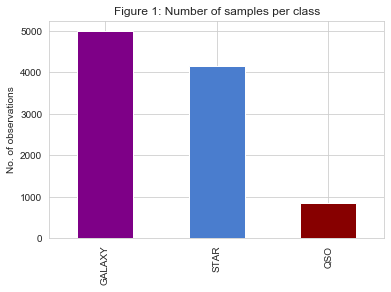

In [ ]:
df['class'].value_counts()

star_color='#4a7dce'
galaxy_color='#7e0087'
qso_color='#870000'

array_color=[star_color, galaxy_color, qso_color]

df['class'].value_counts().plot(kind='bar',title='Figure 1: Number of samples per class', color=['#7e0087','#4a7dce','#870000'], );
plt.ylabel('No. of observations')

print(df['class'].value_counts())

## Distribution of the variables in each class

**Figure 2** (below) contains plots of the probability density for the six most useful feature variables. We can see that the spectral information for each class overlaps quite a bit, but that each class has a different distribution shape. Stars have values which tend to spread out more, whereas Galaxies and Quasars have sharper peaks and less spread. From these distributions we conclude that: 

- the distributions for r, i, but specifically z, seem to be the best candidate variables to help resolve between classes.
- as each distribution does clearly differentiate between each class, this will mitigate to some extent potential problems caused by the low proportion of Quasars in the dataset.
- The peaks for the u band almost entirely overlap. We might be able to drop this feature without loss of resolution. 
- The plot for the redshift data is influenced predominantly by the large clustering of values around zero redshift for Stars, making the graph unreadable. We plot the redshift for each class in **Figure 3** to observe it's distribution better. 

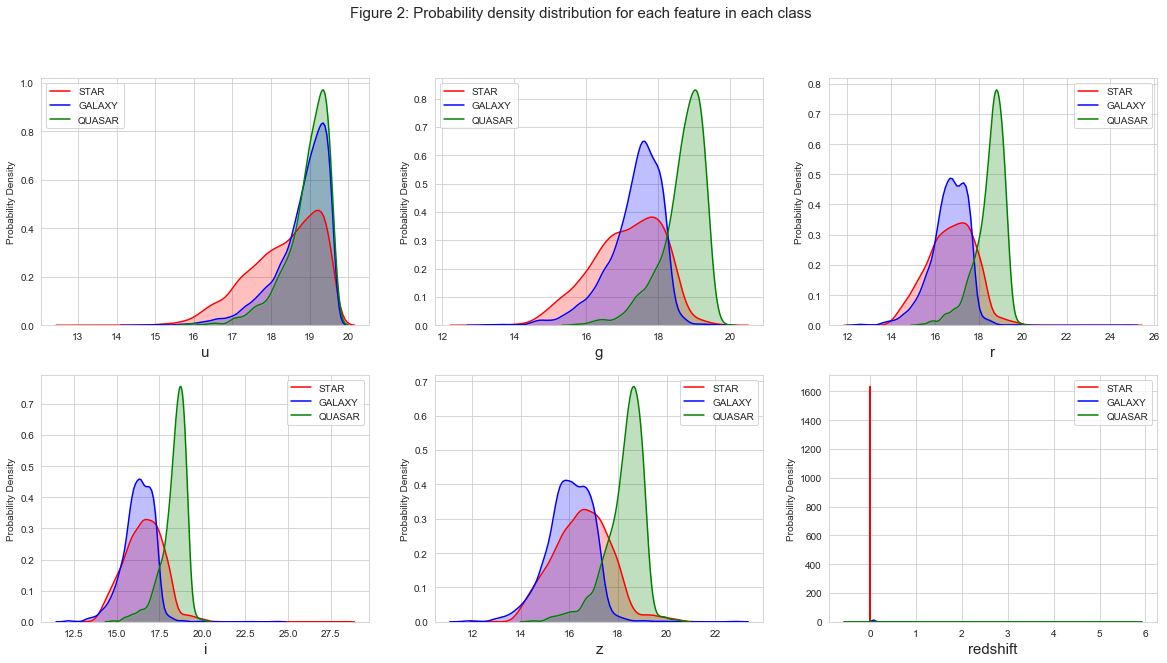

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
i = 0
for column in df.columns:
    if column not in ['objid', 'ra', 'dec', 'class']:
        i = i + 1
        plt.subplot(2,3,i)
        ax = sns.kdeplot(df[df['class']=='STAR'][column], color='red', shade=True, label='STAR')
        ax = sns.kdeplot(df[df['class']=='GALAXY'][column], color='blue', shade=True, label='GALAXY')
        ax = sns.kdeplot(df[df['class']=='QSO'][column], color='green', shade=True, label='QUASAR')
        
        plt.suptitle('Figure 2: Probability density distribution for each feature in each class', fontsize=15)
        ax.set_xlabel(column, fontsize=15)
        ax.set_ylabel("Probability Density", fontsize=10)
        ax.legend(fontsize=10)
       

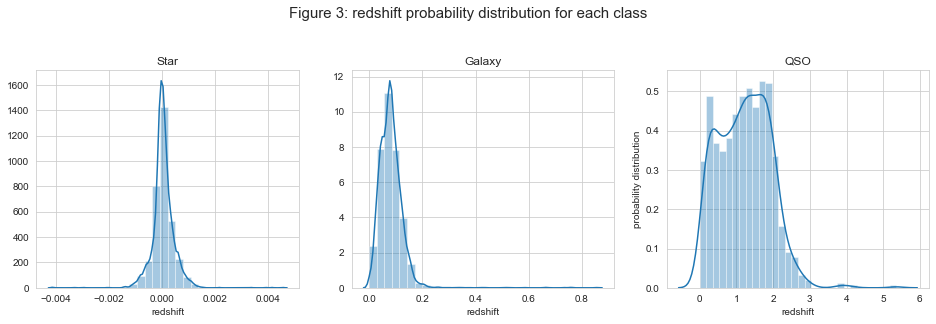

In [ ]:
# plot for the redshift distribution of each class. 
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4), sharey=False)
plt.ylabel('probability distribution')
ax = sns.distplot(df[df['class']=='STAR'].redshift, bins = 30, ax = axes[0], kde = True)
ax.set_title('Star')
ax = sns.distplot(df[df['class']=='GALAXY'].redshift, bins = 30, ax = axes[1], kde = True)
ax.set_title('Galaxy')
plt.ylabel('probability distribution')
ax = sns.distplot(df[df['class']=='QSO'].redshift, bins = 30, ax = axes[2], kde = True)
ax = ax.set_title('QSO')
plt.suptitle('Figure 3: redshift probability distribution for each class', fontsize= 15, y = 1.1)

plt.show()

In **Figure 3** we can see from the x axis that the redshift distributions hardly overlap. Redshift values for Stars are mostly condensed around the origin and ranges from roughly -0.004 to 0.004. For Galaxies, the redshift values mostly range between 0 and 0.2. For Quasars, these values range from 0 to 6. This gives us a good indication that the redshift feature will help us resolve the classes very effectively. This is also a good physical result and a validation of the curation of the dataset, as we know that Stars have little to no redshift, as they are very close astronomical objects. Galaxies have more redshift, as they are further away from us. On the other hand Quasars are older, incredibly bright astronomical objects, which are further away than most Galaxies and hence their spectral information is much more shifted towards red.

## Correlation between variables

In **Figure 4** we can observe the correlation matrices for all eight feature values. There are four key observations:

- The ra and dec values are not correlated to the other feature variables. This is not entirely surprising, but given the presence of galactic clusters in the sky we might have encountered a correlation between redshift and positional information. In this small random sample, this is not the case, but would be worth investigating further in larger datasets. 
- The g, r, i, and z bands are highly correlated as they are all spectral bands. The astronomical objects under observation are not monochromatic, therefore we expect correlation between 'adjacent' frequency/wavelength bands [2].
- The u band is correlated to the g, r, i, and z bands, but to a much lesser extent. This makes sense as UV is farther removed from the other bandwidths. 
- The redshift data is not correlated to the five spectral bands in the case of Stars, but we see a correlation between redshift and spectral information for Stars and Quasars. The correlation is stronger for near infrared, infrared and red bands. Quasars show more correlation because the spectral information is even more shifted towards red than for Galaxies


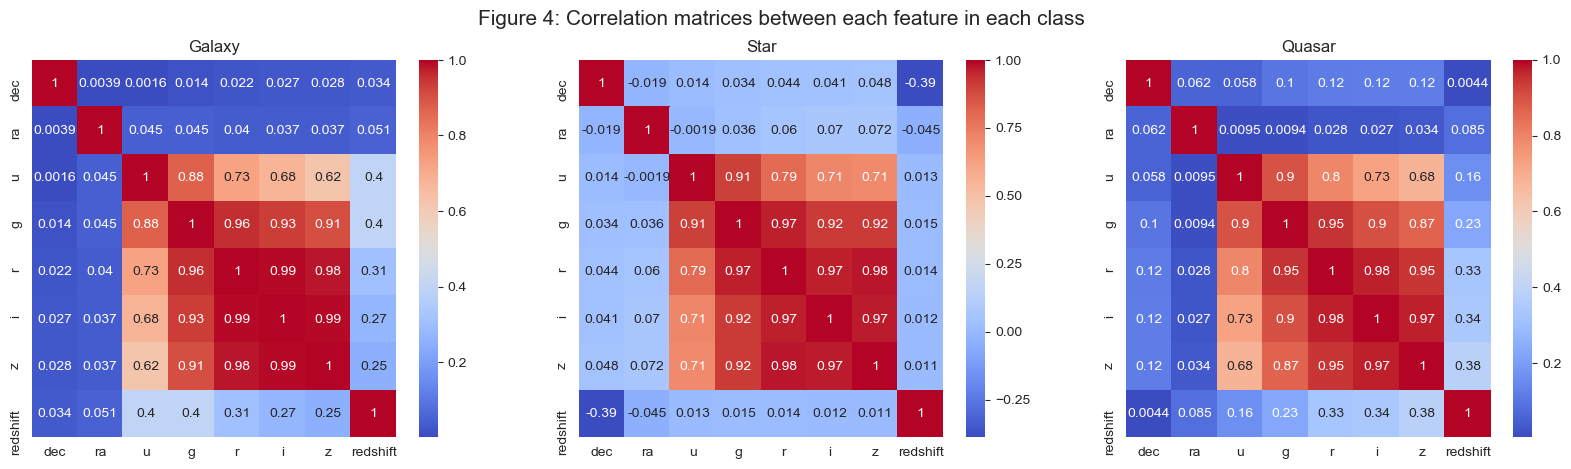

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 5))
fig.set_dpi(100)
ax = sns.heatmap(df[df['class']=='GALAXY'][['dec', 'ra', 'u', 'g', 'r', 'i', 'z', 'redshift']].corr(), ax = axes[0], cmap='coolwarm', annot=True)
ax.set_title('Galaxy')
ax = sns.heatmap(df[df['class']=='STAR'][['dec', 'ra','u', 'g', 'r', 'i', 'z', 'redshift']].corr(), ax = axes[1], cmap='coolwarm', annot=True)
ax.set_title('Star')
ax = sns.heatmap(df[df['class']=='QSO'][['dec', 'ra','u', 'g', 'r', 'i', 'z', 'redshift']].corr(), ax = axes[2], cmap='coolwarm', annot=True)
ax = ax.set_title('Quasar')
plt.suptitle('Figure 4: Correlation matrices between each feature in each class', fontsize=15)

plt.show()

## Transformation of the redshift variable

The redshift values range from -0.0041 to 5.3539, but most observations fall between 0 and 0.5 (see **Figure 5**). This highly skewed distribution caused problems with our initial attempts at gradient descent, a common fix for this problem is to take the natural logarithm, which preserves the order of the data values but reduces the skew [3]. Note that because in a minority of cases redshift values are negative (if the object in question is moving towards the viewer, instead of away, as would normally be the case), we first add 0.005 to each value and then take the logarithm. The right hand plot in **Figure 5** illustrates the effect of this transformation.

In [ ]:
data = df.copy()

# we change the scale for redshift as it is an extremly good classifier, hence causing probabilities to collapse 
# to 0 within the softmax probability scores --> then the log within cost function has a math error. 
data['log_redshift'] = -np.log(0.05 + data['redshift'])
data = data.drop(['redshift'], axis = 1)

[]

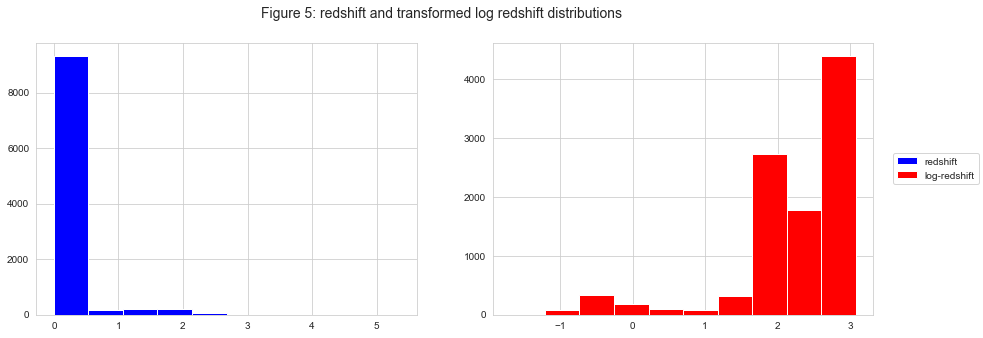

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

#####----HISTOGRAM OF REDSHIFT----#####
axes[0].hist(df['redshift'], bins = 10, color= 'blue', label = "redshift")

#####----HISTOGRAM OF LOG REDSHIFT----#####
axes[1].hist(data['log_redshift'], bins = 10, color= 'red', label = "log-redshift")
plt.suptitle('Figure 5: redshift and transformed log redshift distributions', fontsize=14)
fig.legend(loc='center right')

plt.plot()

# Training and results

## Evaluating the predictive power of different feature variables

The eight feature variables can be grouped into three broad categories:
- Redshift.
- Spectral data (u, g, r, i, z).
- Positional data ('ra' and 'dec').

We assess the relative importance of each category by applying mini-batch gradient descent to each feature category in isolation, using the 'cross_validation' function.

In [ ]:
# checking the predictive power of the redshift variable (which correlates with distance)
data_distance = df.drop(['objid', 'dec', 'ra', 'z', 'i', 'r', 'g', 'u'], axis = 1)
data_distance['log_redshift'] = -np.log(0.05 + data_distance['redshift'])
data_distance = data_distance.drop(['redshift'], axis = 1)
exceptions = ['log_redshift']
data_proc_dis = data_preprocessing(data_distance, exceptions)
print(pd.DataFrame(data_proc_dis[0:5,])) # checking data structure

     0         1    2
0  1.0  1.774765  0.0
1  1.0 -0.204940  1.0
2  1.0  3.013049  2.0
3  1.0  3.010808  2.0
4  1.0  2.208248  0.0


In [ ]:
results_distance = cross_validation(data_proc_dis, 5000, 0.01, 0.0005, 5, 250)

Processed set 0 - Training Set Size: 8000 , Accuracy: 98.513  - Testing Set Size: 2000 , Accuracy: 98.35
Processed set 1 - Training Set Size: 8000 , Accuracy: 98.5  - Testing Set Size: 2000 , Accuracy: 98.35
Processed set 2 - Training Set Size: 8000 , Accuracy: 98.413  - Testing Set Size: 2000 , Accuracy: 98.4
Processed set 3 - Training Set Size: 8000 , Accuracy: 98.5  - Testing Set Size: 2000 , Accuracy: 98.3
Processed set 4 - Training Set Size: 8000 , Accuracy: 98.4  - Testing Set Size: 2000 , Accuracy: 98.75
Average Testing Accuracy %: 98.43
Standard Deviation: 0.163


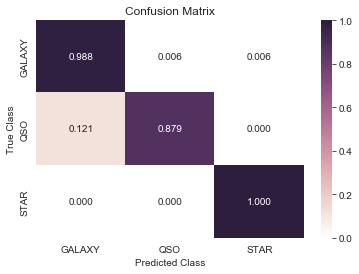

In [ ]:
plot_confusion_matrix(results_distance)

Redshift is clearly an excellent predictor. With all other feature values removed from the dataset, mini-batch gradient descent applied to redshift yields:

- Total accuracy of 98.44% (averaged across the five validation splits).
- Relatively low mis-classification rates in all categories. The 87.9% accuracy rating for Quasars is broadly in line with what we expect, given the relatively low number of examples and the easy misclassification as a Galaxy for lower redshift values (hence for Quasars that are closer to us and relatively younger).

In [ ]:
# checking the predictive power of the spectral information variables
data_spectral = df.drop(['objid', 'dec', 'ra', 'redshift'], axis = 1)
data_spectral.head(3)
data_proc_spec = data_preprocessing(data_spectral)
print(pd.DataFrame(data_proc_spec[0:5,]))

     0         1         2         3         4         5    6
0  1.0  0.869887  0.616894  0.313672  0.243174  0.354614  0.0
1  1.0  0.918977  0.873508  0.500229  0.406426  0.626205  1.0
2  1.0  0.710726  0.561505  0.331062  0.276314  0.427866  2.0
3  1.0  0.745066  0.582677  0.343175  0.286064  0.439847  2.0
4  1.0  0.918600  0.663255  0.350298  0.269144  0.392073  0.0


In [ ]:
results_spectral = cross_validation(data_proc_spec, 5000, 0.01, 0.0005, 5, 250)

Processed set 0 - Training Set Size: 8000 , Accuracy: 92.737  - Testing Set Size: 2000 , Accuracy: 93.05
Processed set 1 - Training Set Size: 8000 , Accuracy: 93.0  - Testing Set Size: 2000 , Accuracy: 93.3
Processed set 2 - Training Set Size: 8000 , Accuracy: 92.562  - Testing Set Size: 2000 , Accuracy: 91.9
Processed set 3 - Training Set Size: 8000 , Accuracy: 92.388  - Testing Set Size: 2000 , Accuracy: 92.65
Processed set 4 - Training Set Size: 8000 , Accuracy: 92.7  - Testing Set Size: 2000 , Accuracy: 93.5
Average Testing Accuracy %: 92.88
Standard Deviation: 0.566


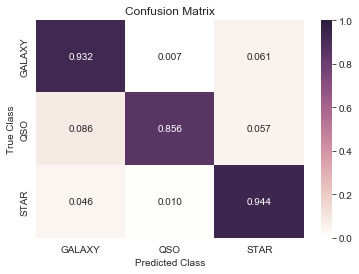

In [ ]:
plot_confusion_matrix(results_spectral)

The five spectral bands have good predictive power. Mini-batch gradient descent applied to u, g, r, i, and z yields:
- Total accuracy of 92.88% (averaged across the five validation splits). This is notably less than for the redshift values alone, but still demonstrates significant predictive potential.
- More significant mis-classification of Quasars than expected, because **Figure 2** shows clear discrimination between Galaxies/Stars and Quasars.

In [ ]:
# checking the predictive power of the location variables (ra and dec)
data_location = df.drop(['objid', 'z', 'i', 'r', 'g', 'u', 'redshift'], axis = 1)
data_proc_loc = data_preprocessing(data_location)
print(pd.DataFrame(data_proc_loc[0:5,]))

     0         1         2    3
0  1.0  0.699116  1.000000  0.0
1  1.0  0.700633  0.999977  1.0
2  1.0  0.690215  0.999861  2.0
3  1.0  0.714871  0.999201  2.0
4  1.0  0.703284  0.999160  0.0


In [ ]:
results_location = cross_validation(data_proc_loc, 5000, 0.01, 0.0005, 5, 250)

Processed set 0 - Training Set Size: 8000 , Accuracy: 50.625  - Testing Set Size: 2000 , Accuracy: 50.7
Processed set 1 - Training Set Size: 8000 , Accuracy: 41.7  - Testing Set Size: 2000 , Accuracy: 40.8
Processed set 2 - Training Set Size: 8000 , Accuracy: 45.938  - Testing Set Size: 2000 , Accuracy: 45.55
Processed set 3 - Training Set Size: 8000 , Accuracy: 49.95  - Testing Set Size: 2000 , Accuracy: 50.1
Processed set 4 - Training Set Size: 8000 , Accuracy: 48.675  - Testing Set Size: 2000 , Accuracy: 48.7
Average Testing Accuracy %: 47.17
Standard Deviation: 3.649


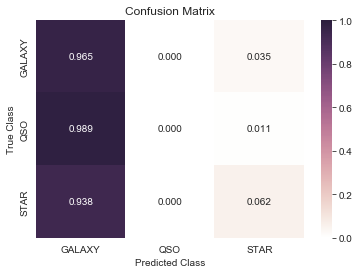

In [ ]:
plot_confusion_matrix(results_location)

The positional data has no predictive power. Mini-batch gradient descent applied to 'ra' and 'dec' yields total accuracy of 47.17% (averaged across the five validation splits). Given the predominance of Galaxies and Stars in the dataset, this is effectively no better than random chance. As mentioned above, it is worth investigating if this is still the case in a larger, more exhaustive dataset, where the positional information might acquire more importance as there are numerous galactic clusters in the sky and therefore positional information might give the algorithm an edge in classifying between Quasars and Galaxies. However, in our small random dataset, this is not the case. 

In [ ]:
# benchmarking against a pure random variable to check lower bound
data_random = np.random.uniform(size= df.shape[0])

df_rand = df.copy()
data_rand = pd.DataFrame(data_random)
df_rand.insert (1, 'random', data_rand) # Insert the column of random numbers in the dataframe

In [ ]:
df_rand_drop = df_rand.drop(['objid', 'ra', 'dec', 'z', 'i', 'r', 'g', 'u', 'redshift'], axis = 1)
data_proc_rand = data_preprocessing(df_rand_drop)
print(pd.DataFrame(data_proc_rand[0:5,]))

     0         1    2
0  1.0  0.433405  0.0
1  1.0  0.437356  1.0
2  1.0  0.270127  2.0
3  1.0  0.182792  2.0
4  1.0  0.353284  0.0


In [ ]:
results_rand = cross_validation(data_proc_rand, 5000, 0.01, 0.0005, 5, 250)

Processed set 0 - Training Set Size: 8000 , Accuracy: 50.0  - Testing Set Size: 2000 , Accuracy: 49.9
Processed set 1 - Training Set Size: 8000 , Accuracy: 41.7  - Testing Set Size: 2000 , Accuracy: 40.8
Processed set 2 - Training Set Size: 8000 , Accuracy: 49.362  - Testing Set Size: 2000 , Accuracy: 49.0
Processed set 3 - Training Set Size: 8000 , Accuracy: 49.95  - Testing Set Size: 2000 , Accuracy: 50.1
Processed set 4 - Training Set Size: 8000 , Accuracy: 50.113  - Testing Set Size: 2000 , Accuracy: 49.45
Average Testing Accuracy %: 47.85
Standard Deviation: 3.545


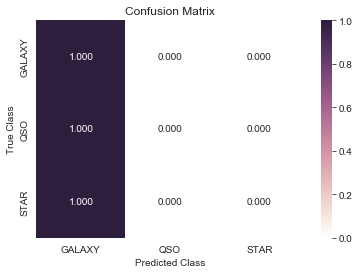

In [ ]:
plot_confusion_matrix(results_rand)

Mini-batch gradient descent applied to random numbers (as a benchmark) yields total accuracy of 47.85% (averaged across the five validation splits), as we would expect. This is on par with the results of the test run on the positional data, further emphasising that 'ra' and 'dec' have no predictive power.

## Training with redshift and spectral information

Based on the correlation between variables we've observed, we can drop some of the spectral information, as they are highly correlated and we wish to gain computational efficiency. We will drop 'g' and 'r'. We will also drop 'ra' and 'dec' as they show no predictive power.

In [ ]:
data_drop = data.drop(['objid', 'dec', 'ra', 'r', 'g'], axis = 1)  # Drop column we don't need.

In [ ]:
data_drop.head(5)

,u,i,z,class,log_redshift
0,18.73973,15.89451,15.59012,GALAXY,1.774765
1,19.06426,18.54449,18.63809,QSO,-0.204940
2,17.68753,16.43245,16.41220,STAR,3.013049
3,17.91455,16.59072,16.54666,STAR,3.010808
4,19.06177,16.31607,16.01051,GALAXY,2.208248


In [ ]:
exceptions = ['log_redshift']
data_proc = data_preprocessing(data_drop, exceptions)
print(pd.DataFrame(data_proc[0:5,]))

     0         1         2         3         4    5
0  1.0  0.869887  0.243174  0.354614  1.774765  0.0
1  1.0  0.918977  0.406426  0.626205 -0.204940  1.0
2  1.0  0.710726  0.276314  0.427866  3.013049  2.0
3  1.0  0.745066  0.286064  0.439847  3.010808  2.0
4  1.0  0.918600  0.269144  0.392073  2.208248  0.0


In [ ]:
results_proc = cross_validation(data_proc, 5000, 0.01, 0.0005, 5, 250)

Processed set 0 - Training Set Size: 8000 , Accuracy: 98.525  - Testing Set Size: 2000 , Accuracy: 98.9
Processed set 1 - Training Set Size: 8000 , Accuracy: 98.575  - Testing Set Size: 2000 , Accuracy: 98.75
Processed set 2 - Training Set Size: 8000 , Accuracy: 98.7  - Testing Set Size: 2000 , Accuracy: 98.2
Processed set 3 - Training Set Size: 8000 , Accuracy: 98.662  - Testing Set Size: 2000 , Accuracy: 98.45
Processed set 4 - Training Set Size: 8000 , Accuracy: 98.6  - Testing Set Size: 2000 , Accuracy: 98.7
Average Testing Accuracy %: 98.6
Standard Deviation: 0.247


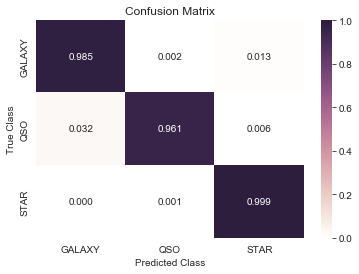

In [ ]:
plot_confusion_matrix(results_proc)

Applying mini-batch gradient descent to redshift, u, i, and z yields:

- Total accuracy of 98.6% (averaged across the five validation splits).
- A near perfect classification of Stars (which is the most clearly distinguishable when it comes to redshift values and is in line with the result obtained using only the redshift feature), an excellent classification of Galaxies, and reasonable classification of Quasars (which is better than using only redshift). The increase in the Quasar classification score is a justification for using the spectral information in addition to redshift, although the effect is marginal on the overall accuracy score as Quasars only represent 8.5% of the dataset. 

There are two key observations:

- The overall accuracy of 98.6% is only marginally better than the 98.43% accuracy achieved with redshift alone.
- The standard deviation of 0.247 is marginally worse than the 0.163 achieved with redshift alone. This is to be expected given the larger number of features.

The results clearly show that redshift is the most useful feature for classification. But our earlier tests showed that the spectral data also has excellent predictive potential, which explains the marginal increase in accuracy for Quasars. Nevertheless it seems some other feature for Quasar classification would have to be found. An idea that came to us when looking at representation of Quasars is using a feature which gives information on the geometry of the object. 

## Scatter plot 

To finish and visualize our results, we create a 3D scatter plotting the different classes (**Figure 6**)), as well as a 2D scatter plot (**Figure 7**) with the classification decision boundaries. First, and out of expediency, we redefine a 'cross-validation_one_set' function so as to obtain the values for only one training set, which is what we will plot.

In [ ]:
def cross_validation_one_set(data, max_iters, l_rate, reg_lambda, k_splits, batch_size):
    
    """ This function automates the training of data through cross-validation of the different data splits"""
    
    data_features_split, data_class_split = data_split(data, k_splits)
    results = []
    accuracies = []
    confusions = []
    
    for i in [0]:
        
        training_data, training_class, testing_data, testing_class = test_and_training_data(data_features_split, data_class_split, i)
        
       
        
        result = mini_batch_gradient_descent(training_data, training_class, max_iters, l_rate, reg_lambda, batch_size)
        
        conf = confusion_matrix(testing_data, testing_class, result)
        
        acc = accuracy(training_data, training_class, testing_data, testing_class, result)
        # mean_accuracy
        #print('Processed set',i,'- Training Set Size:', len(training_data),', Accuracy:', round(acc[0],3),' - Testing Set Size:', len(testing_data),', Accuracy:', round(acc[1],3) )
       
        results.append(result)
        accuracies.append(acc)
        confusions.append(conf)
    
    #avg_accuracy = np.mean(np.array(accuracies).T[1])
    #std_accuracy = np.std(np.array(accuracies).T[1])
    #print('Average Testing Accuracy %:', round(avg_accuracy,3))
    #print('Standard Deviation:', round(std_accuracy,3))
    return accuracies, results, confusions
        

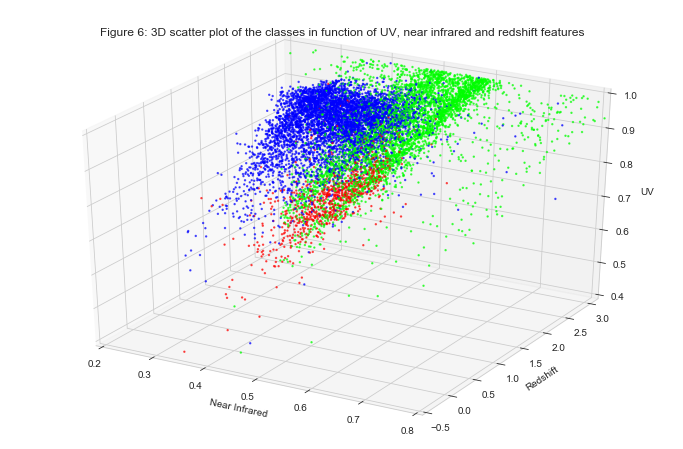

In [ ]:
x = data_proc.T[3] # z - near-infrared
y = data_proc.T[4] # redshift
z = data_proc.T[1] # UV

label = data_proc.T[5] # class
colors = ['blue','green','red']

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(0.2,0.8)
ax.set_ylim3d(-0.5,3.1)
ax.set_zlim3d(0.4,1)

ax.set_xlabel("Near Infrared")
ax.set_ylabel("Redshift")
ax.set_zlabel("UV")

ax.scatter(x, y, z, c= label, marker='o', alpha=0.60, cmap=plt.cm.brg, s=2)
ax.set_title("Figure 6: 3D scatter plot of the classes in function of UV, near infrared and redshift features")
#ax.legend()

plt.show()


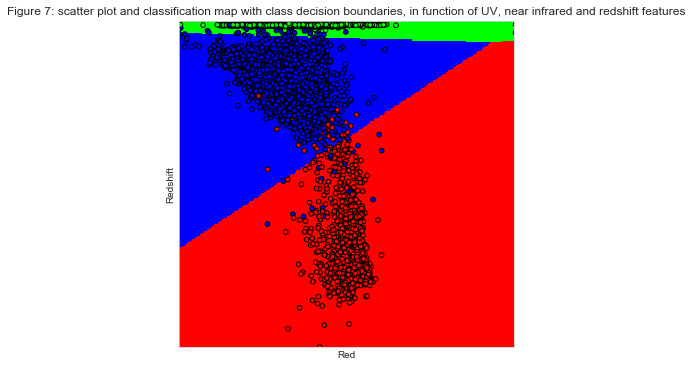

In [ ]:
data = df.copy()

data_scatter = df.drop(['objid', 'dec', 'ra','z', 'i', 'g', 'u'], axis = 1)
data_scatter['log_redshift'] = -np.log(0.05 + data_scatter['redshift'])
data_scatter = data_scatter.drop(['redshift'], axis = 1)

exceptions = ['log_redshift']
scatter_plot = data_preprocessing(data_scatter, exceptions)

x = scatter_plot.T[1] # red
y = scatter_plot.T[2] # redshift
cat = scatter_plot.T[3] # class 

Nx= 200
Ny= 200

x_grid = np.arange(np.min(x), np.max(x), (np.max(x)-np.min(x)) / Nx)
y_grid = np.arange(np.min(y), np.max(y), (np.max(y)-np.min(y)) / Ny)

testing_data = np.ones([Nx * Ny, 3])
predicted_grid = np.zeros([Nx, Ny])

count = 0
for i in range(len(x_grid)):
    for j in range(len(y_grid)):
        testing_data[count, 1] = x_grid[i]
        testing_data[count, 2] = y_grid[j]
        count +=1

result = cross_validation_one_set(scatter_plot, 1000, 0.01, 0.0005, 5, 250)
Theta = result[1][0][0]

prob_test = softmax(np.dot(testing_data, Theta)) 

for i in range(len(testing_data)):
    predicted_grid[i // Nx, i % Nx] = np.argmax(prob_test[i])

xx, yy = np.meshgrid(np.arange(np.min(x), np.max(x), (np.max(x)-np.min(x)) / Nx), np.arange(np.min(y), np.max(y), (np.max(y)-np.min(y)) / Ny) )
plt.figure(1, figsize=(6, 6))
plt.pcolormesh(xx, yy, predicted_grid.T, cmap=plt.cm.brg)

# Plot also the training points
plt.scatter(x, y, c=cat, edgecolors='k', cmap=plt.cm.brg, s=22)
plt.xlabel('Red')
plt.ylabel('Redshift')
plt.title("Figure 7: scatter plot and classification map with class decision boundaries, in function of UV, near infrared and redshift features")

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
#plt.legend()
plt.show()


As we can see in **Figure 7** the classification decision boundaries are in line with the clustering of the data points and most observations were correctly classified. In red we have Quasars, in Blue Galaxies and in Green Stars. 

## Convergence test

In [ ]:
def convergence_test(data, iterations, batch_sizes, l_rate=0.001, reg_lambda=0.0, k_splits=5):
    
    results_matrix = np.zeros([len(batch_sizes),len(iterations)])
    
    for i in range(len(iterations)):
        for j in range(len(batch_sizes)):
            result = (cross_validation_one_set(data, iterations[i], l_rate, reg_lambda, k_splits, batch_sizes[j]))
            results_matrix[j,i] = result[0][0][1]
            
    return results_matrix

In [ ]:
iterations = [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 32, 40, 50, 60, 70, 80, 90, 100, 250, 500]
batch_sizes = [10, 32, 50, 100, 200, 400, 800, 1000, 2000, 4000, 7900]

conv_matrix = convergence_test(data_proc, iterations, batch_sizes) # this run takes a long time

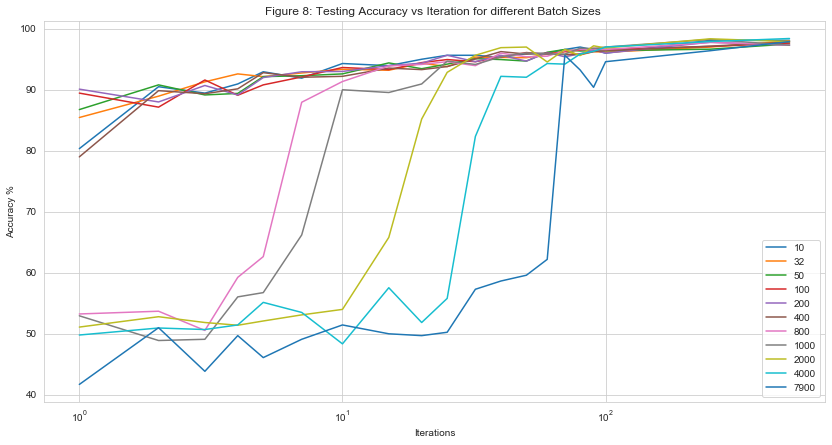

In [ ]:
plt.figure(figsize=(14,7))
for i in range(len(conv_matrix)):
    plt.semilogx(iterations, conv_matrix[i],label=batch_sizes[i])

plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy %")
plt.title(r'Figure 8: Testing Accuracy vs Iteration for different Batch Sizes ')

plt.show()

Because the mini-batch algorithm updates the $\theta$ (model parameter) values after running gradient descent on each mini-batch, and not the entire training set, good accuracy can be achieved with very few iterations by using small batches. Using larger batch sizes, however, gives smoother convergence and marginally better accuracy, at the expense of increased computational load (iterations). This is clearly illustrated by Figure 8:

- Mini-batch gradient descent converges more smoothly the larger the batch size, but requires more iterations to achieve  optimum accuracy.
- The convergence exhibits greater jitter when the batch size is small, but converges much more rapidly.

The largest batch is the size of the training set, hence equivalent to batch gradient descent, and only reaches maximum accuracy after many iterations. Stochastic gradient descent would be equivalent to running mini-batch with batch size = 1. The computational cost would also be much higher in this case, but accuracies are also high.

Our choice of 250 as a batch size would seem to be a reasonable compromise.

## Future challenges

There is scope for further work in this area:
- Acquire additional geometric information to help better resolve Quasars.
- Compare our multi-class logistic classification model against other ML supervised learning techniques, for example using scikit-learn.

## Conclusions

Exploratory data analysis revealed that the SDSS spectral bands were all highly correlated, and that the positional values were of no predictive utility. This is broadly in line with our prior knowledge of the problem. We were therefore able to throw away four of the original eight feature variables.

Using Softmax Regression, we were able to achieve classification accuracy of 98.61%, with reasonable consistency across all three classes.

## References

[1] https://www.kaggle.com/lucidlenn/sloan-digital-sky-survey
(Accessed 26/10/2019)

[2] https://arxiv.org/pdf/1002.3701.pdf
(Accessed 04/12/2019)

[3] https://datascience.stackexchange.com/questions/40089/what-is-the-reason-behind-taking-log-transformation-of-few-continuous-variables
(Accessed 07/12/2019)

[4] https://stats.stackexchange.com/questions/377966/cross-entropy-loss-for-one-hot-encoding/377967#377967
(Accessed 26/11/2019)

[5] http://deeplearning.stanford.edu/tutorial/supervised/SoftmaxRegression/
(Accessed 26/11/2019)

[6] http://rasbt.github.io/mlxtend/user_guide/classifier/SoftmaxRegression/
(Accessed 27/11/2019)

[7] https://gluon.mxnet.io/chapter02_supervised-learning/softmax-regression-scratch.html
(Accessed 29/11/2019)

[8] https://gist.github.com/awjuliani/5ce098b4b76244b7a9e3
(Accessed 29/11/2019)

[9] https://github.com/karan6181/Softmax-Classifier/blob/master/softmaxClassifier.py
(Accessed 29/11/2019)

[10] https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a
(Accessed 08/12/2019)

[11] https://www.scikit-yb.org/en/latest/api/classifier/confusion_matrix.html
(Accessed 09/12/2019)